In [1]:
import matplotlib
import warnings
warnings.filterwarnings("ignore", category=matplotlib.cbook.MatplotlibDeprecationWarning)
%matplotlib inline

In [2]:
from siphon.radarserver import RadarServer
rs = RadarServer('http://thredds-aws.unidata.ucar.edu/thredds/radarServer/nexrad/level2/S3/')

In [3]:
from datetime import datetime, timedelta
query = rs.query()
query.stations('KLVX').time(datetime.utcnow())

time=2019-08-07T15%3A45%3A19.408753&stn=KLVX

In [4]:
rs.validate_query(query)

True

In [5]:
catalog = rs.get_catalog(query)

In [6]:
ds = list(catalog.datasets.values())[0]
ds.access_urls

{'OPENDAP': 'http://thredds-aws.unidata.ucar.edu/thredds/dodsC/nexrad/level2/S3/2019/08/07/KLVX/KLVX20190807_153436_V06',
 'HTTPServer': 'http://thredds-aws.unidata.ucar.edu/thredds/fileServer/nexrad/level2/S3/2019/08/07/KLVX/KLVX20190807_153436_V06',
 'CdmRemote': 'http://thredds-aws.unidata.ucar.edu/thredds/cdmremote/nexrad/level2/S3/2019/08/07/KLVX/KLVX20190807_153436_V06'}

In [7]:
from siphon.cdmr import Dataset
data = Dataset(ds.access_urls['CdmRemote'])

In [8]:
import numpy as np
def raw_to_masked_float(var, data):
    # Values come back signed. If the _Unsigned attribute is set, we need to convert
    # from the range [-127, 128] to [0, 255].
    if var._Unsigned:
        data = data & 255

    # Mask missing points
    data = np.ma.array(data, mask=data==0)

    # Convert to float using the scale and offset
    return data * var.scale_factor + var.add_offset

def polar_to_cartesian(az, rng):
    az_rad = np.deg2rad(az)[:, None]
    x = rng * np.sin(az_rad)
    y = rng * np.cos(az_rad)
    return x, y

In [9]:
sweep = 0
ref_var = data.variables['Reflectivity_HI']
ref_data = ref_var[sweep]
rng = data.variables['distanceR_HI'][:]
az = data.variables['azimuthR_HI'][sweep]

In [10]:
ref = raw_to_masked_float(ref_var, ref_data)
x, y = polar_to_cartesian(az, rng)

In [11]:
from metpy.plots import ctables  # For NWS colortable
ref_norm, ref_cmap = ctables.registry.get_with_steps('NWSReflectivity', 5, 5)

In [12]:
import matplotlib.pyplot as plt
import cartopy

def new_map(fig, lon, lat):
    # Create projection centered on the radar. This allows us to use x
    # and y relative to the radar.
    proj = cartopy.crs.LambertConformal(central_longitude=lon, central_latitude=lat)

    # New axes with the specified projection
    ax = fig.add_subplot(1, 1, 1, projection=proj)

    # Add coastlines
    ax.coastlines('50m', 'black', linewidth=2, zorder=2)

    # Grab state borders
    state_borders = cartopy.feature.NaturalEarthFeature(
        category='cultural', name='admin_1_states_provinces_lines',
        scale='50m', facecolor='none')
    ax.add_feature(state_borders, edgecolor='black', linewidth=1, zorder=3)
    
    return ax

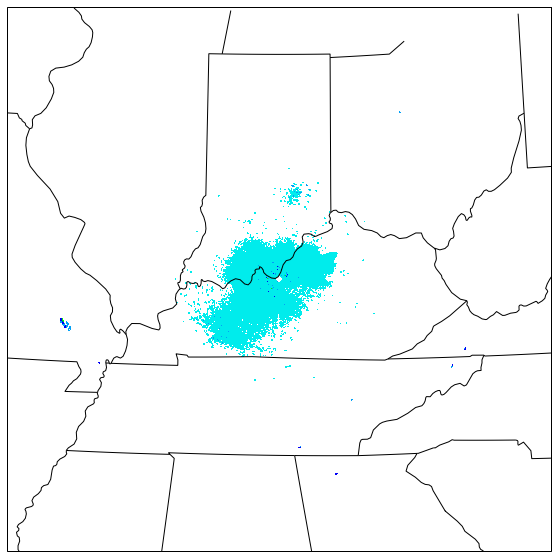

In [13]:
fig = plt.figure(figsize=(10, 10))
ax = new_map(fig, data.StationLongitude, data.StationLatitude)
ax.pcolormesh(x, y, ref, cmap=ref_cmap, norm=ref_norm, zorder=0)

In [14]:
query = rs.query()
dt = datetime(2012, 10, 29, 15) # Our specified time
query.lonlat_point(-73.687, 41.175).time_range(dt, dt + timedelta(hours=1))

time_start=2012-10-29T15%3A00%3A00&time_end=2012-10-29T16%3A00%3A00&longitude=-73.687&latitude=41.175

In [15]:
cat = rs.get_catalog(query)
list(cat.datasets)


['KOKX20121029_150259_V06.gz',
 'KOKX20121029_150854_V06.gz',
 'KOKX20121029_151451_V06.gz',
 'KOKX20121029_152046_V06.gz',
 'KOKX20121029_152639_V06.gz',
 'KOKX20121029_153234_V06.gz',
 'KOKX20121029_153829_V06.gz',
 'KOKX20121029_154422_V06.gz',
 'KOKX20121029_155017_V06.gz',
 'KOKX20121029_155612_V06.gz']

In [16]:
meshes = []
for item in sorted(cat.datasets.items()):
    # After looping over the list of sorted datasets, pull the actual Dataset object out
    # of our list of items and access over CDMRemote
    ds = item[1]
    data = Dataset(ds.access_urls['CdmRemote'])

    # Pull out the data of interest
    sweep = 0
    rng = data.variables['distanceR_HI'][:]
    az = data.variables['azimuthR_HI'][sweep]
    ref_var = data.variables['Reflectivity_HI']

    # Convert data to float and coordinates to Cartesian
    ref = raw_to_masked_float(ref_var, ref_var[sweep])
    x, y = polar_to_cartesian(az, rng)

    # Plot the data and the timestamp
    mesh = ax.pcolormesh(x, y, ref, cmap=ref_cmap, norm=ref_norm, zorder=0)
    text = ax.text(0.65, 0.03, data.time_coverage_start, transform=ax.transAxes,
                   fontdict={'size':16})
    plt.show()
    # Collect the things we've plotted so we can animate
    meshes.append((mesh, text))

In [17]:
# Set up matplotlib to do the conversion to HTML5 video
import matplotlib
matplotlib.rcParams['animation.html'] = 'html5'

# Create an animation
from matplotlib.animation import ArtistAnimation
ArtistAnimation(fig, meshes)


In [34]:
'{0:%Y}'.format(data.time_coverage_start[0:10])

ValueError: Invalid format specifier

In [35]:
type(data.time_coverage_start)

str

In [36]:
from string import Template
t = Template('Hey, $name!')

In [39]:
t.substitute(name=data.time_coverage_start)

'Hey, 2012-10-29T15:56:15Z!'